<h1 style='color:blue' align='center'>Image Classification Using Convolutional Neural Network (CNN)</h1>

<h2>Step 1: Import required libraries</h2>

In [59]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
from torchvision import models
from torchsummary import summary
import pathlib
import matplotlib.pyplot as plt

In [60]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
print(device)

cpu


In [62]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

<h2>Step 2: Load and prepair the dataset</h2>


In [65]:
from google.colab import drive
drive.mount('/content/drive')
train_path = "drive/MyDrive/Pets"
test_path = "drive/MyDrive/Test"

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)




Mounted at /content/drive


<h2>Optional: plot some images from the dataset</h2>

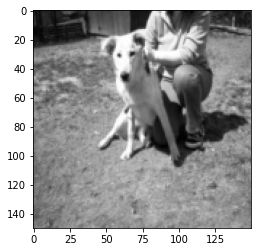

In [66]:
for i, (images,labels) in enumerate(train_loader):
      if torch.cuda.is_available():
          images=Variable(images.cuda())
          labels=Variable(labels.cuda())
          break
      break
plt.imshow(images[0][0], cmap='gray')  # graph it
plt.show()  # display!

<h2>Step 3: Build/Train the model</h2>


In [67]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
            



model=ConvNet(num_classes=6).to(device)


In [68]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [69]:
num_epochs=10
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [70]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
   
    
       

Epoch: 0 Train Loss: tensor(1.2760) Train Accuracy: 0.4117647058823529 Test Accuracy: 0.5
Epoch: 1 Train Loss: tensor(16.0236) Train Accuracy: 0.5882352941176471 Test Accuracy: 0.5
Epoch: 2 Train Loss: tensor(14.9924) Train Accuracy: 0.5 Test Accuracy: 0.47619047619047616
Epoch: 3 Train Loss: tensor(7.2469) Train Accuracy: 0.5980392156862745 Test Accuracy: 0.5
Epoch: 4 Train Loss: tensor(6.0532) Train Accuracy: 0.6862745098039216 Test Accuracy: 0.5
Epoch: 5 Train Loss: tensor(7.6442) Train Accuracy: 0.6078431372549019 Test Accuracy: 0.5
Epoch: 6 Train Loss: tensor(1.7750) Train Accuracy: 0.8529411764705882 Test Accuracy: 0.5714285714285714
Epoch: 7 Train Loss: tensor(4.3731) Train Accuracy: 0.7156862745098039 Test Accuracy: 0.6190476190476191
Epoch: 8 Train Loss: tensor(1.2264) Train Accuracy: 0.8823529411764706 Test Accuracy: 0.5
Epoch: 9 Train Loss: tensor(1.5206) Train Accuracy: 0.8627450980392157 Test Accuracy: 0.5


<h2>Step 4: Save the model and load it into anther variable</h2>



In [71]:
 #Save the best model
if test_accuracy>best_accuracy:
    torch.save(model.state_dict(),'best_checkpoint.model')
    best_accuracy=test_accuracy
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(num_classes=6)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
)

<h2>Bonus: Learn how to extract the paramters from the model</h2>


In [ ]:
# Please don't leave me blank :'(

<h2>Step 5: Link your recourses</h2>


https://github.com/gaurav67890/Pytorch_Tutorials/blob/master/cnn-scratch-inference.ipynb

https://www.youtube.com/watch?v=9OHlgDjaE2I